In [105]:
!pip install geotext

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
from textblob import TextBlob
from geotext import GeoText

In [4]:
IS_SAMPLE_ANALYSIS = False
TARGET = 'google'
if IS_SAMPLE_ANALYSIS:
    TARGET += '_sample'
FIGURE_SIZE = (12,7)

In [5]:
cols = ['text','timestamp','user','tweet_source','tweet_id','user_location','source_device']
tweets = pd.read_csv('../data/' + TARGET + '.csv', names=cols)

In [76]:
tweets.tail()

,text,timestamp,user,tweet_source,tweet_id,user_location,source_device,clean_text,is_retweet,hashtags,polarity,subjectivity,datetime
448089,yes I am a woman. yes I like women. no I will ...,1.584861e+09,daddyleslii,1241299091700584448,1241624890488180737,"San Diego, CA",Twitter for iPhone,yes i am a woman. yes i like women. no i will ...,True,,0.400000,0.800000,2020-03-22 12:46:56.824
448090,@WalkFearlessly We legit had to fight our own ...,1.584861e+09,0rdinaryDemiguy,1241624891608240128,1241624891608240128,"Richmond, VA",Twitter for Android,we legit had to fight our own community on goo...,False,,0.396429,0.783929,2020-03-22 12:46:57.091
448091,Now playing deezy styles - In a Hour dl the...,1.584861e+09,WwuRadio,1241624902236606464,1241624902236606464,NaN,Radio.co now playing,now playing deezy styles in a hour dl the app ...,False,,0.136364,0.500000,2020-03-22 12:46:59.625
448092,💥INTERNATIONAL EXOLS PLEASE READ :(\n\nSomeone...,1.584861e+09,PhngAnhKen2,1241190912744509440,1241624921366605825,NaN,Twitter for Android,international els please read someone had the ...,True,,0.666667,0.666667,2020-03-22 12:47:04.186
448093,17 March 2020\n\n#GodofAbraham\n#Jesus\n\n#pho...,1.584861e+09,jeffdavisshow,1239983661791039489,1241624932536156161,Pflugerville Texas USA,Twitter for Android,march godofabraham jesus photo photography pho...,True,#GodofAbraham #Jesus #photo #photography #phot...,1.000000,1.000000,2020-03-22 12:47:06.849


## Tweet distribution over time

In [7]:
dates = pd.DataFrame(tweets['timestamp']/1000)

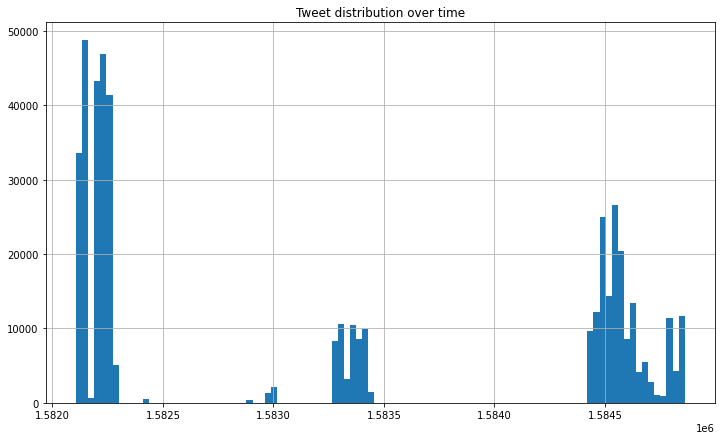

In [8]:
dates.hist(bins=100, figsize=FIGURE_SIZE)
plt.title('Tweet distribution over time')
plt.show()

## Cleaning
- Remove
    - All urls
    - '#' form infront of hashtags
    - mentions
    - emojis
    - Non ASCII chanracters

In [9]:
import re
import preprocessor as p

# Don't remove hastags
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.NUMBER, p.OPT.SMILEY, p.OPT.RESERVED, p.OPT.MENTION)

NOT_BASIC_LATIN_PATTERN = re.compile(u'[^\u0000-\u007F]')
PUNCTUATIONS_PATTERN = re.compile(r'[\#\$\%\&\(\)\*\+\-\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]')
MULTIPLE_SPACES_PATTERN = re.compile(r' +')

def clean_text(text):
    text = text.lower()
    text = p.clean(text) # Clean using tweet-preprocessor except hashtags
    text = NOT_BASIC_LATIN_PATTERN.sub(' ', text) # Remove everything except basic latin
    text = re.sub(r'&amp;', 'and', text)
    text = PUNCTUATIONS_PATTERN.sub(' ', text) # Remove all punctuations
    text = MULTIPLE_SPACES_PATTERN.sub(' ', text) # Remove multiple consequent spaces
    return text.strip()

In [10]:
%%time
tweets['clean_text'] = tweets['text'].apply(lambda x: clean_text(x))
tweets[['text','clean_text']].head()

CPU times: user 48.3 s, sys: 734 ms, total: 49 s
Wall time: 49.7 s


,text,clean_text
0,#GMBUpdate\nDo you know the recent #googlemybu...,gmbupdate do you know the recent googlemybusin...
1,Our digital marketing technology is your lever...,our digital marketing technology is your lever...
2,#Google's “Project Nightingale” is meant to co...,google's project nightingale is meant to colle...
3,#NowPlaying Dance in The Night Away by Tripple...,nowplaying dance in the night away by tripple'...
4,@ClassicLibScot @ronague @scotpolitik @putey_p...,it's main media news. google it. even the bbc ...


## Analysis of words used in cleaned tweets

### Most used words

In [11]:
import nltk
from nltk.text import Text
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt

tokenizer = TweetTokenizer()

all_clean_text = []
for text in tweets['clean_text']:
    for t in tokenizer.tokenize(text):
        all_clean_text.append(t)
all_clean_text = Text(all_clean_text)

In [12]:
freq_dist = nltk.FreqDist(all_clean_text)

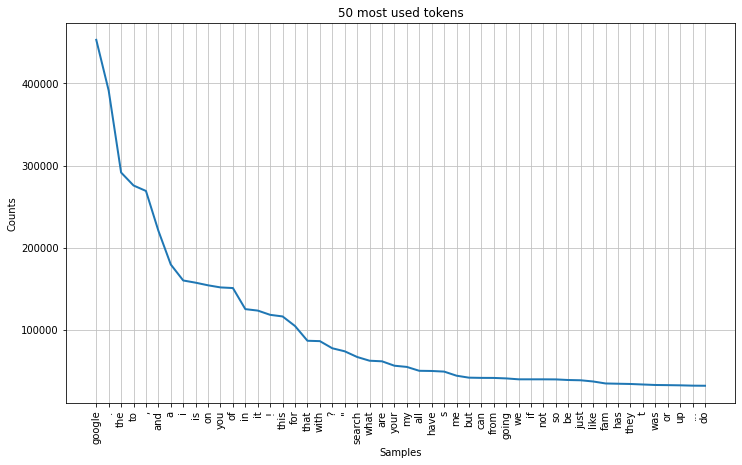

In [13]:
plt.figure(figsize=FIGURE_SIZE)
freq_dist.plot(50, title="50 most used tokens")

### Most used words after removing stop words and punctuations

In [14]:
# nltk.download('stopwords')

from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english'))

# Add 'google' and 'search' in stop words
stop_words.add('google')
stop_words.add('search')
# Remove stopwords
freq_dist = nltk.FreqDist(dict((word, freq) for word, freq in freq_dist.items() if word not in stop_words and word.isalpha()))

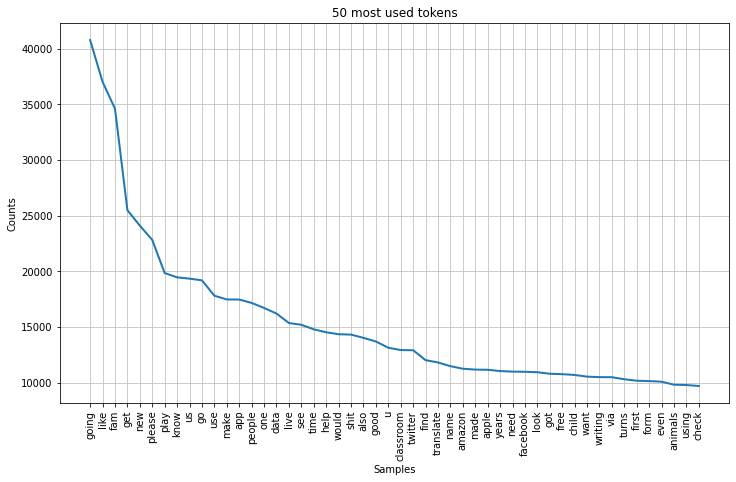

In [15]:
plt.figure(figsize=FIGURE_SIZE)
freq_dist.plot(50, title="50 most used tokens")

## Feature Creation

### 'is_retweet' from 'tweet_source' and 'tweet_id'

In [16]:
def is_retweet(x):
    return x[0] != x[1]

In [17]:
tweets['is_retweet'] = tweets[['tweet_source','tweet_id']].apply(lambda x: is_retweet(x), axis=1)

In [18]:
tweets[['tweet_source','tweet_id','is_retweet']].head()

,tweet_source,tweet_id,is_retweet
0,1230070481195356165,1230070481195356165,False
1,1227642551227895809,1230070485590913025,True
2,1229832031913357318,1230070495015526402,True
3,1230070519627702273,1230070519627702273,False
4,1230070526711926785,1230070526711926785,False


### 'hashtags' from 'text'

In [19]:
HASHTAG_PATTERN = re.compile(r'#\w*')
def get_hashtags(text):
    return ' '.join(HASHTAG_PATTERN.findall(text))

In [20]:
tweets['hashtags'] = tweets['text'].apply(lambda x: get_hashtags(x))

In [21]:
tweets[['text','hashtags']].head()

,text,hashtags
0,#GMBUpdate\nDo you know the recent #googlemybu...,#GMBUpdate #googlemybusiness #GMB #DigitalMark...
1,Our digital marketing technology is your lever...,#LucidLeverage #DigitalMarketingAgency #SEO #R...
2,#Google's “Project Nightingale” is meant to co...,#Google #healthdata #ethics #userprivacy
3,#NowPlaying Dance in The Night Away by Tripple...,#NowPlaying #Funk #DiscoMusic #Oldies #70s #Di...
4,@ClassicLibScot @ronague @scotpolitik @putey_p...,


### 'contry' from 'user_location'

In [134]:
def get_country(data):
    country_men = list(GeoText(data).country_mentions.keys())
    if len(country_men) > 0:
        return country_men[0]
    return ''

In [135]:
%%time
tweets['country'] = tweets['user_location'].fillna('').apply(lambda x: get_country(x))

CPU times: user 6.28 s, sys: 0 ns, total: 6.28 s
Wall time: 6.54 s


In [136]:
tweets['country'].describe()

count     448094
unique       218
top             
freq      291132
Name: country, dtype: object

## Sentiment Analysis

In [22]:
def get_sentiment(text):
    return TextBlob(text).sentiment

In [23]:
%%time
sentiment = tweets['clean_text'].apply(lambda x: get_sentiment(x))
tweets['polarity'] = sentiment.apply(lambda x: x[0])
tweets['subjectivity'] = sentiment.apply(lambda x: x[1])

In [24]:
tweets[['clean_text','polarity','subjectivity']].head()

,clean_text,polarity,subjectivity
0,gmbupdate do you know the recent googlemybusin...,0.300000,0.500000
1,our digital marketing technology is your lever...,0.333333,0.333333
2,google's project nightingale is meant to colle...,0.400000,0.750000
3,nowplaying dance in the night away by tripple'...,0.000000,0.000000
4,it's main media news. google it. even the bbc ...,0.166667,0.333333


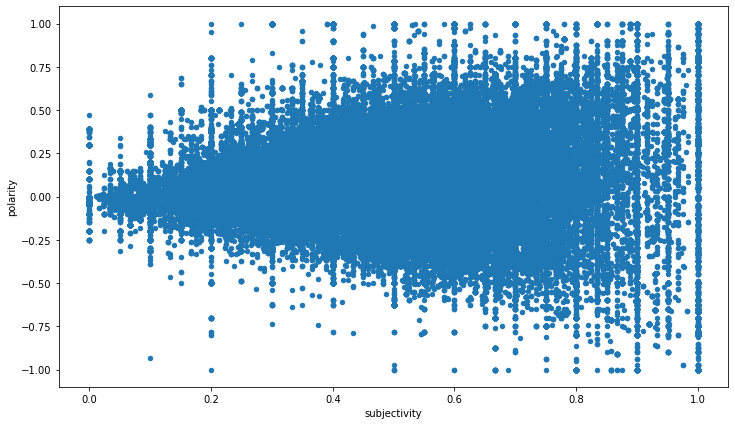

In [25]:
tweets[['polarity','subjectivity']].plot(kind='scatter', x='subjectivity', y='polarity',figsize=FIGURE_SIZE)

From the above graph we can see, as the polarity becomes extreme, the subjectivity also increases. That is, more a person is opinionated, more subjective there views are.

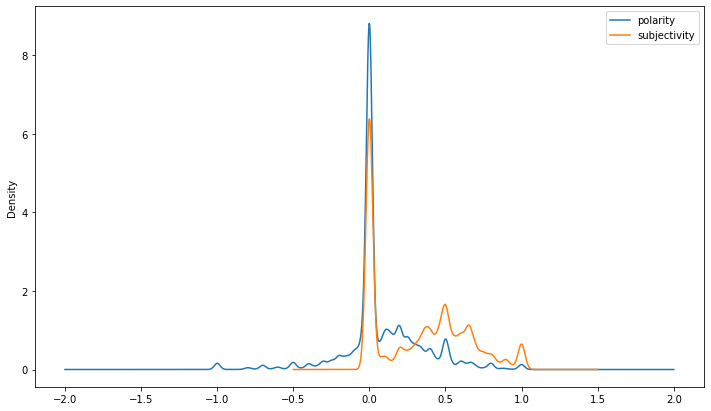

In [26]:
tweets[['polarity','subjectivity']].plot(figsize=FIGURE_SIZE, kind='density')

### Sentiment Over Time

In [27]:
def get_datetime(ts):
    return datetime.fromtimestamp(ts)

In [28]:
# Add datetime column
tweets['datetime'] = tweets['timestamp'].apply(lambda x: get_datetime(x))

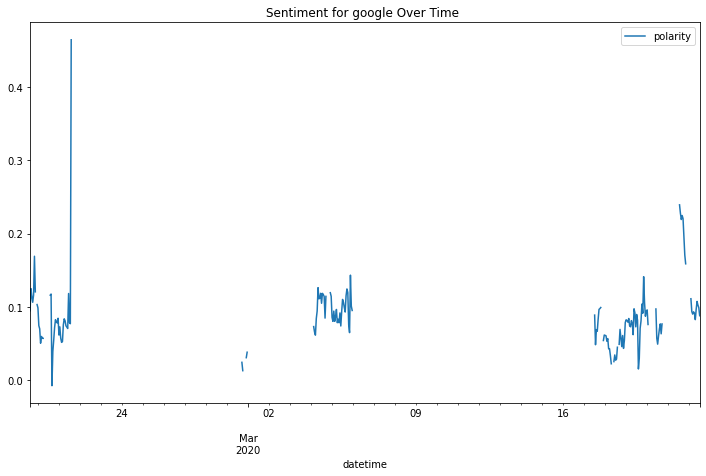

In [29]:
tweets[['datetime','polarity']].groupby(pd.Grouper(key='datetime', freq='H')).mean().plot(figsize=FIGURE_SIZE)
plt.title(f'Sentiment for {TARGET} Over Time ')
plt.show()

### Top Twitter Clients

In [30]:
client_popularity = tweets[['polarity','source_device']].groupby('source_device').size().sort_values(ascending=False)

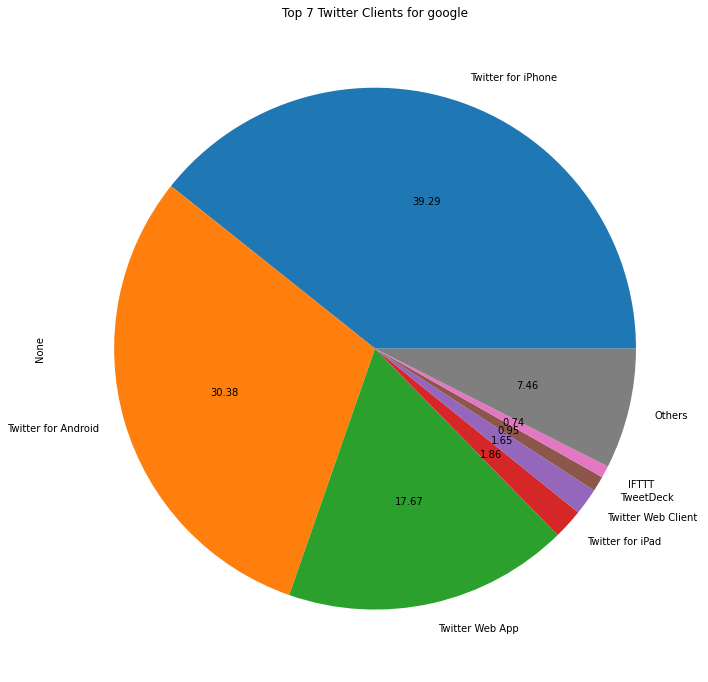

In [31]:
client_popularity[:7].append(pd.Series(client_popularity[7:].sum(), index=['Others'])).plot(kind='pie', autopct='%.2f', figsize=(12,12))
plt.title(f'Top 7 Twitter Clients for {TARGET}')
plt.show()

### Average Sentiment of people using particular twitter clients

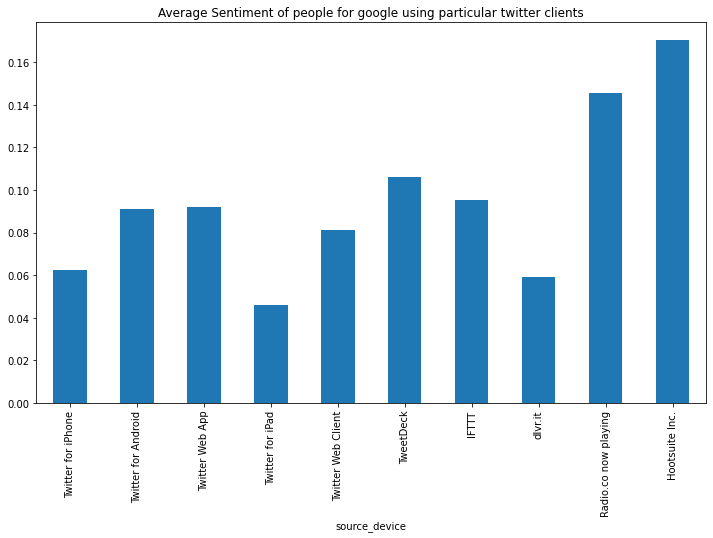

In [32]:
tweets[['datetime','polarity','source_device']].groupby('source_device').agg({
    'polarity': ['size', 'mean']
}).sort_values(('polarity','size'), ascending=False)[('polarity','mean')][:10].plot(kind='bar', figsize=FIGURE_SIZE)
plt.title(f'Average Sentiment of people for {TARGET} using particular twitter clients')
plt.show()